<!-- Warning (yellow) -->
<div style="background-color: #fff3cd; border-left: 4px solid #ffc107; padding: 12px; margin: 10px 0;">
<strong>⚠️ Warning</strong><br>
Your warning text here.
</div>

<!-- Success/Tip (green) -->
<div style="background-color: #d4edda; border-left: 4px solid #28a745; padding: 12px; margin: 10px 0;">
<strong>💡 Tip</strong><br>
Your tip text here.
</div>

<!-- Danger/Important (red) -->
<div style="background-color: #f8d7da; border-left: 4px solid #dc3545; padding: 12px; margin: 10px 0;">
<strong>🚨 Important</strong><br>
Critical information here.
</div>

# Getting Started with ML Training in XNAT

This notebook demonstrates the recommended practices for manipulating data from XNAT and implementing a basic machine learning training and evaulation workflow. 

This notebook is divided into 5 sections. 
#### Topic Covered
1. Setting up your Jupyter Environment
2. Understanding XNAT's Data Structure & the XNATpy SDK
3. Data Pulling & Filtering
4. Data Preparation & Train/Val/Test Splits
5. Running Model Training
6. Saveing, Loading, & Evaluating the Model

### Training accomplished in nb

<div style="background-color: #e7f3fe; border-left: 4px solid #2196F3; padding: 12px; margin: 10px 0;">
<strong>📌 Prerequisites</strong><br>
Before starting, ensure you have:
<ul>
<li>A reachable XNAT server URL</li>
<li>Credentials with appropriate project permissions</li>
<li><code>xnat</code> (xnatpy) and optionally <code>pydicom</code> installed</li>
</ul>
</div>

## 1. Setting up your Jupyter Environment

### 1.1 Installing Imports

Before we begin installing imports, we can see that a large number of common libraries are already installed for us!

In [16]:
# Here we can take a quick look at how many packages come pre-installed in the environment
!(conda list | head -10) 2>/dev/null && echo "" && echo "Found $(conda list | tail -n +4 | wc -l) packages in your environment!"

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                  2_kmp_llvm    conda-forge
aiohappyeyeballs          2.6.1                    pypi_0    pypi
aiohttp                   3.12.15                  pypi_0    pypi
aiosignal                 1.4.0                    pypi_0    pypi
alabaster                 1.0.0                    pypi_0    pypi
alembic                   1.16.5                   pypi_0    pypi

Found 474 packages in your environment!


In [17]:
# Standard package & local utility imports
import logging
import xnat
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import os
from datetime import datetime
from pathlib import Path
from rich.tree import Tree
from rich import print
from requests.auth import HTTPBasicAuth
from collections import Counter
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
from torchvision import models
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

# Local imports from our utility scripts
from src.utils.directory_tree import show_directory_tree
from src.utils.torch_data_loading import load_dicom_data_with_logging
from src.utils.data_handling import fetch_xnat_metadata
from src.utils.xnat_voila_dashboards import (
    class_distribution_dashboard,
    training_history_dashboard,
    confusion_matrix_dashboard,
    pixel_intensity_dashboard,
    metadata_filter_dashboard,
)
from src.models.efficientnet import create_efficientnet_b0

### 1.2 Initiating Logging 

After imports, we highly recommend initializing log tracking for tracking errors & unexpected outcomes.

In [18]:
# Create our log directory
Path.mkdir(Path('logs'), exist_ok=True)

logging.basicConfig(
    filename=f"logs/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# First log
logging.info("Logging initiatated...")

### 1.3 GPU Check
Now that our logging is initialized, let's check that our environment is GPU enabled.

In [19]:
# Here we create a small function to check our GPU status & log it
def check_gpu_status() -> torch.device:
      """Basic fn for checking what is available in user's env."""
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      cuda_available = torch.cuda.is_available()
      cuda_version = torch.version.cuda
      gpu_count = torch.cuda.device_count()
      gpu_name = torch.cuda.get_device_name(0) if cuda_available else "N/A"

      logging.info(f"Device: {device}")
      logging.info(f"CUDA available: {cuda_available}")
      logging.info(f"CUDA version: {cuda_version}")
      logging.info(f"GPU count: {gpu_count}")
      logging.info(f"GPU name: {gpu_name}")

      return device

In [20]:
# Calling our fn
device = check_gpu_status()

## 2. Understanding XNAT's Data Structure & the XNATpy SDK

### 2.1 Exploring the Mounted Data Directory

In this first section, we explore how we can directly interact with our mounted project data!

This will allow you to interact with your data in the same manner as you would if it was available locally!

In [21]:
# Here is a quick example of looking at our mounted data
for i, (root, dirs, files) in enumerate(os.walk("/data")):
  print(root)
  dirs[:] = dirs[:5]
  if i >= 7:
      break

/data

/data/projects

/data/projects/InBreastProject

/data/projects/InBreastProject/experiments

/data/projects/InBreastProject/experiments/20588458_BIRADS_2_1798085734

/data/projects/InBreastProject/experiments/20588458_BIRADS_2_1798085734/SCANS

/data/projects/InBreastProject/experiments/20588458_BIRADS_2_1798085734/SCANS/1_2_826_0_1_3680043_8_498_69195413700
476430552174544204581670404

/data/projects/InBreastProject/experiments/20588458_BIRADS_2_1798085734/SCANS/1_2_826_0_1_3680043_8_498_69195413700
476430552174544204581670404/secondary

In [22]:
# Here we use a custom function for better visualization of our data directory
show_directory_tree(
  "/data",
  max_depth=8,
  max_items=2,
  max_files=3,
  depth_labels={
      1: "Project Label",
      3: "Experiment Label",
      5: "Scan Number",
  }
)

📁 /data
└── 📁 projects
    └── 📁 InBreastProject (Project Label)
        └── 📁 experiments
            ├── 📁 20586908_BIRADS_2_1158302830 (Experiment Label)
            │   └── 📁 SCANS
            │       └── 📁 1_2_826_0_1_3680043_8_498_10675674632970931711656630713501244231 (Scan Number)
            │           └── 📁 secondary
            │               ├── 📄 20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm
            │               └── 📄 
            │                   scan_1_2_826_0_1_3680043_8_498_10675674632970931711656630713501244231_secondary_cat
            │                   alog.xml
            ├── 📁 20586908_BIRADS_2_1554025637 (Experiment Label)
            │   └── 📁 SCANS
            │       └── 📁 1_2_826_0_1_3680043_8_498_98752643858555190245490297679306193402 (Scan Number)
            │           └── 📁 secondary
            │               ├── 📄 20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm
            │               └── 📄 
            │                   scan_1_2_826_0_1_3680043_8_498_98752643858555190245490297679306193402_secondary_cat
            │                   alog.xml
            └── ... and more directories

### 2.2 Understanding the XNATpy SDK

Now let's explore how XNATpy can make working with XNAT Data more efficient!

<!-- Warning (yellow) -->
<div style="background-color: #fff3cd; border-left: 4px solid #ffc107; padding: 12px; margin: 10px 0;">
<strong>⚠️ Warning</strong><br>
Pass = Alias token
</div>


<!-- Warning (yellow) -->
<div style="background-color: #fff3cd; border-left: 4px solid #ffc107; padding: 12px; margin: 10px 0;">
<strong>❓ Why use XNATpy when our data is mounted ❓</strong><br>
XNATpy provides a quick and efficient way to parse and direct DICOM metadata. It can also be used to obtain the mounted path for objects in XNAT!
</div>


<!-- Success/Tip (green) -->
<div style="background-color: #d4edda; border-left: 4px solid #28a745; padding: 12px; margin: 10px 0;">
<strong>💡 Tip</strong><br>
XNAT's Jupyter notebooks come pre-configured with your user credentials as Env variables!
    
  - `XNAT_HOST`
  - `XNAT_USER`
  - `XNAT_PASS`
</div>


In [23]:
# Assign & Call Env variables  
host = os.environ['XNAT_HOST']
username = os.environ['XNAT_USER']
password = os.environ['XNAT_PASS']
connection = xnat.connect(
    host,
    user=os.environ['XNAT_USER'],
    password=os.environ['XNAT_PASS']
)

[WARNING] Detected a redirect from https://tap.embarklabs.ai to https://tap.embarklabs.ai:443/, using https://tap.embarklabs.ai:443/ from now on
[WARNING] Found an unsupported version (1.9.3), trying 1.7 compatible model builder
Exception in thread XNATpyKeepAliveThread:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/http/client.py", line 1390, in getresponse
    response.begin()
  File "/opt/conda/lib/python3.11/http/client.py", line 325, in begin


### Checking Connection & Data
To ensure we have successfully connected to XNAT and that we have access to our data, let's show a few key objects from our project.


In [24]:
# Check that our project exists
PROJECT_ID = "InBreastProject"
if PROJECT_ID not in connection.projects:
    raise ValueError(
        f"Project '{PROJECT_ID}' not found on this XNAT server."
        f"Available projects: {list(connection.projects.keys())}"
    )
project = connection.projects[PROJECT_ID]
print(f"{project.name} project found!")

# Check our experiments with our DICOMs exist.
print(f"Number of experiments found: {len(project.experiments)}")

InBreastDataset project found!

Number of experiments found: 410

<!-- Success/Tip (green) -->
<div style="background-color: #d4edda; border-left: 4px solid #28a745; padding: 12px; margin: 10px 0;">
<strong>💡 Tip</strong><br>
We strongly recommend using top level hyperparameter config structures! They facilitate conducting multiple training runs and with provenance tracking!
</div>

## Data Loading & Training Configs

After confirming our data is available, we now need to pull the data and supply it to our model in the correct format. 

Here was are using Pytorch's DataLoaders to transform and organize our data before passing it to our model. 

We are also going to set a few key hyperparameters to be used throughout our training.

In [29]:
# Hyperparameters - all configurable settings for this training run
HPARAMS = {
    # Run identification
    "run_name": "EfficientNet-B0 with augmentation_dim448_e30",
    "model_name": "efficientnet_b0",
    "notes": "EfficientNet-B0 with data augmentation, dropout, and label smoothing. Img Dims [448,448], epochs: 30.",

    # Data loading
    "batch_size": 4,
    "image_size": 448,
    "num_workers": 3,
    "val_split": 0.2,

    # Model architecture
    "dropout_rate": 0.3,
    "freeze_backbone": False,

    # Training
    "num_epochs": 10,
    "learning_rate": 1e-4,
    "weight_decay": 0.01,
    "label_smoothing": 0.1,

    # Scheduler
    "scheduler_factor": 0.5,
    "scheduler_patience": 5,

    # Early stopping
    "early_stop_patience": 10,
}


### Data Loading
For clarity, much of the data loading code has been abstracted through the `load_dicom_data_with_logging` function. 

In [30]:
# Here we load the data into our dataloader class
dataloaders = load_dicom_data_with_logging(
    "InBreastProject",
    batch_size=HPARAMS["batch_size"],
    num_workers=HPARAMS["num_workers"],
    val_split=HPARAMS["val_split"],
    image_size=HPARAMS["image_size"],
)

# We then separate the data into training and validate subsets
images_train, labels_train = next(iter(dataloaders['train']))
images_val, labels_val = next(iter(dataloaders['val']))

# And finally we check the dimensions of the data 
print(f"Training batch shape: {images_train.shape}")
print(f"Validation batch shape: {images_val.shape}")

Training batch shape: torch.Size([4, 3, 448, 448])

Validation batch shape: torch.Size([4, 3, 448, 448])

#### Checking our Labels
Next, we double check we have the correct number of labels. 

Our images are labeled according to BI-RADS assessment. We should see 6 unique labels from our dataset.

In [12]:
ys = torch.tensor(dataloaders['train'].dataset.labels)
print("Unique train labels:", sorted(ys.unique().tolist()))

Unique train labels:
[0, 1, 2, 3, 4, 5]

## Exploring Our Data

### Visualizations
With our data pulled and organized appropriately, let's pull a few examples and examine what our data looks like. 

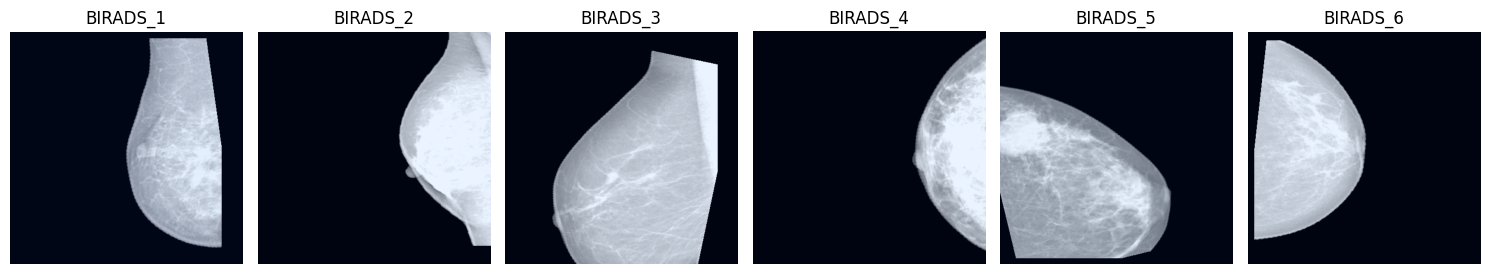

In [13]:
class_names = dataloaders['train'].dataset.classes
dataset = dataloaders['train'].dataset

# Build a mapping of class label -> first index with that label
label_to_idx = {}
for idx, label in enumerate(dataset.labels):
    if label not in label_to_idx:
        label_to_idx[label] = idx
    if len(label_to_idx) == len(class_names):
        break  # Found one of each, stop early

fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

for ax, (label_value, class_name) in enumerate(zip(sorted(label_to_idx.keys()), class_names)):
    idx = label_to_idx[label_value]
    image, _ = dataset[idx]  # Directly index the dataset
    image = image.permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())
    axes[ax].imshow(image)
    axes[ax].set_title(class_name)
    axes[ax].axis('off')

plt.tight_layout()
plt.show()

### Checking the Metadata

After visually inspecting our data, let's take a look at the DICOM metadata as well.

<!-- Warning (yellow) -->
<div style="background-color: #fff3cd; border-left: 4px solid #ffc107; padding: 12px; margin: 10px 0;">
<strong>⚠️ Warning</strong><br>
You will notice that some of this metadata may be missing. As a de-identified dataset, many of these headers have been redacted!
</div>

<!-- Success/Tip (green) -->
<div style="background-color: #d4edda; border-left: 4px solid #28a745; padding: 12px; margin: 10px 0;">
<strong>💡 Tip</strong><br>
The <code>fetch_xnat_metadata</code> function uses XNATpy to efficiently pull demographic and scan metadata directly from the XNAT server, without needing to parse DICOM files on disk.
</div>

In [28]:
# Fn for pulling metadata w/ xnatpy


# Explantion of xnatpy pulling across projects

In [26]:
# Define the project(s) to pull metadata from
# Can be a single project ID or a list of multiple projects
PROJECTS_LIST = ["InBreastProject","RIDER-LUNG-CT", "NSCLC_RADIOGENOMICS", "NSCLC_RADIOMICS"]  # Add more project IDs as needed, e.g., ["00001", "00002", "RIDER-LUNG-CT"]

# Build a metadata dataframe using XNATpy to pull demographic & scan metadata
# This uses the existing XNAT connection to efficiently fetch metadata from all projects
# With save_csv=True, the dataframe will be cached to disk and loaded on subsequent runs
meta_df = fetch_xnat_metadata(
    project_ids=PROJECTS_LIST,
    connection=connection,  # Reuse the existing c|onnection from section 2.2
    save_csv=True,  # Enable caching to avoid re-fetching on subsequent runs
    csv_filename="xnat_metadata",  # Name of the cached CSV file
)

print(f"Metadata rows: {len(meta_df)}")
print(f"Projects included: {meta_df['project_name'].unique().tolist()}")
meta_df.head()

Loading cached metadata from: logs/saved_df/xnat_metadata.csv


Metadata rows: 469

Projects included: ['InBreastDataset', 'Rider Lung CT']

,project_id,project_name,subject_id,subject_label,gender,age,handedness,experiment_id,experiment_label,experiment_date,...,manufacturer_model_name,station_name,software_versions,series_description,series_number,acquisition_number,instance_number,patient_position,image_orientation_patient,body_part_examined
0,InBreastProject,InBreastDataset,TAP_S00001,024ee3569b2605dc,NaN,NaN,NaN,TAP_E00414,20587994_BIRADS_6_2944864255,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,InBreastProject,InBreastDataset,TAP_S00001,024ee3569b2605dc,NaN,NaN,NaN,TAP_E00434,20588020_BIRADS_2_3396612429,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,InBreastProject,InBreastDataset,TAP_S00001,024ee3569b2605dc,NaN,NaN,NaN,TAP_E00457,20588046_BIRADS_6_2583559448,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,InBreastProject,InBreastDataset,TAP_S00001,024ee3569b2605dc,NaN,NaN,NaN,TAP_E00477,20588072_BIRADS_2_2873555748,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,InBreastProject,InBreastDataset,TAP_S00002,036aff49b8ac84f0,NaN,NaN,NaN,TAP_E00419,20588654_BIRADS_2_1873531261,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filtering and Exploring the Metadata

Use the interactive dashboard below to filter the metadata by various attributes such as project, modality, image dimensions, and more. The dashboard will display distribution charts and allow you to export filtered subsets.

In [ ]:
# Create the filter dashboard
# The dashboard object provides access to filtered/exported data for downstream use
dashboard = metadata_filter_dashboard(
    meta_df,
    on_filter_callback=lambda df: None,  # Optional: callback on every filter change
)

# Display the dashboard
dashboard

In [ ]:
# After filtering and clicking "Export CSV", access the data for downstream use:
# 
# Get the currently filtered DataFrame (updates with every filter change):
# filtered_df = dashboard.get_filtered_df()
#
# Get the last exported DataFrame (set when you click "Export CSV"):
# exported_df = dashboard.get_exported_df()
#
# Example usage:
# subset_df = dashboard.get_exported_df()
# print(f"Working with {len(subset_df)} records")

## Exploring Our Data

Now that we have familizarized ourselves with our data, let's explore the dataset to uncover if there are any issues with our dataset. 

### Class balance and sampling

After inspecting our data we found that the class distribution is unbalanced.

Now we will use the per-class distribution in the training and validation splits to mitigate this imbalance. 

We will also verify how the `WeightedRandomSampler` in our PyTorch `DataLoader` helps compensate for this imbalance. 

Train class distribution:
  0 -> BIRADS_1: 54 samples
  1 -> BIRADS_2: 176 samples
  2 -> BIRADS_3: 19 samples
  3 -> BIRADS_4: 34 samples
  4 -> BIRADS_5: 39 samples
  5 -> BIRADS_6: 6 samples

Validation class distribution:
  0 -> BIRADS_1: 13 samples
  1 -> BIRADS_2: 44 samples
  2 -> BIRADS_3: 4 samples
  3 -> BIRADS_4: 9 samples
  4 -> BIRADS_5: 10 samples
  5 -> BIRADS_6: 2 samples


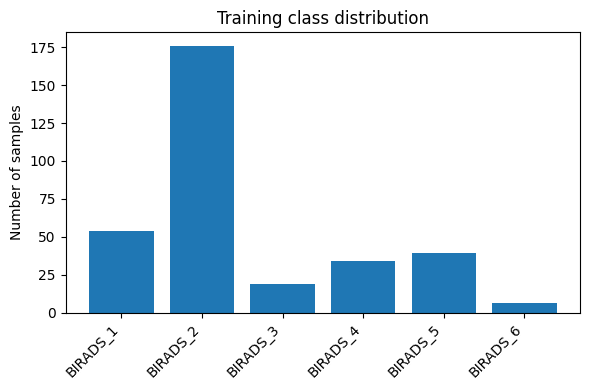

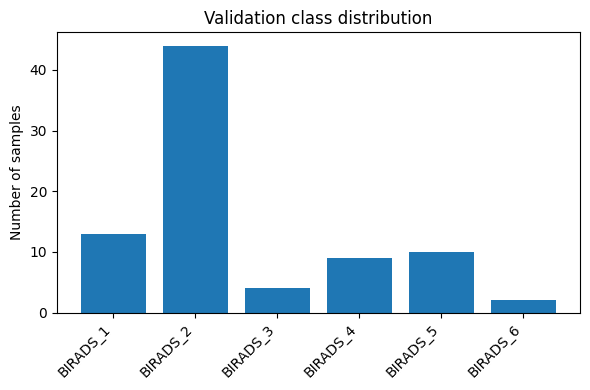

In [14]:
# --- 1. Raw label distribution (what's in the dataset) ---
train_labels = torch.tensor(dataloaders['train'].dataset.labels)
val_labels = torch.tensor(dataloaders['val'].dataset.labels)
class_names = dataloaders['train'].dataset.classes

train_counts = Counter(train_labels.tolist())
val_counts = Counter(val_labels.tolist())

print("Train class distribution:")
for idx, name in enumerate(class_names):
    print(f"  {idx} -> {name}: {train_counts.get(idx, 0)} samples")

print("\nValidation class distribution:")
for idx, name in enumerate(class_names):
    print(f"  {idx} -> {name}: {val_counts.get(idx, 0)} samples")

def plot_class_distribution(counts, class_names, title):
    idxs = range(len(class_names))
    values = [counts.get(i, 0) for i in idxs]
    labels = [class_names[i] for i in idxs]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of samples")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_counts, class_names, "Training class distribution")
plot_class_distribution(val_counts, class_names, "Validation class distribution")

In [15]:
# Interactive class distribution dashboard
class_dist_ui = class_distribution_dashboard(train_labels, val_labels, class_names)
class_dist_ui

## Mitigating the Class Imbalance


We have now explored the class imbalance in our dataset, now let's ammend our Sampler in our Pytorch DataLoader in order to pull classes for training proportionally. 


Sampler mean weight per class:
  0 -> BIRADS_1: mean weight = 0.0185
  1 -> BIRADS_2: mean weight = 0.0057
  2 -> BIRADS_3: mean weight = 0.0526
  3 -> BIRADS_4: mean weight = 0.0294
  4 -> BIRADS_5: mean weight = 0.0256
  5 -> BIRADS_6: mean weight = 0.1667


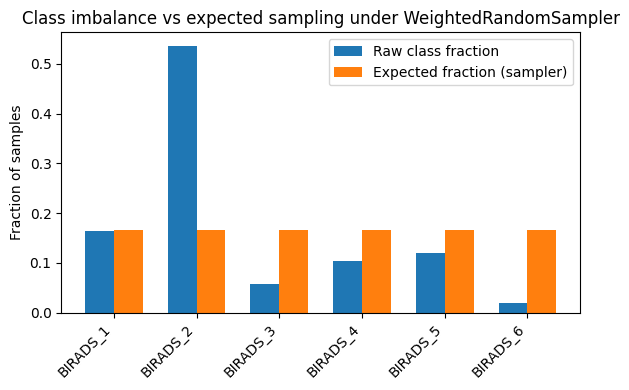

In [16]:
# --- 2. Sampler weights and expected sampling distribution ---
sampler = dataloaders['train'].sampler
if hasattr(sampler, "weights"):
    w = sampler.weights.detach().cpu().numpy()
    y_np = train_labels.numpy()

    print("\nSampler mean weight per class:")
    for idx, name in enumerate(class_names):
        mask = (y_np == idx)
        if mask.any():
            mean_w = float(w[mask].mean())
            print(f"  {idx} -> {name}: mean weight = {mean_w:.4f}")

    # Compute raw fraction vs expected fraction under the sampler
    total_samples = len(y_np)
    total_weight = w.sum()

    raw_frac = []
    expected_frac = []

    for idx, name in enumerate(class_names):
        mask = (y_np == idx)
        n_raw = mask.sum()
        raw_frac.append(n_raw / total_samples if total_samples > 0 else 0.0)

        w_sum = w[mask].sum()
        expected_frac.append(w_sum / total_weight if total_weight > 0 else 0.0)

    # Plot: raw vs expected sampling fraction
    idxs = np.arange(len(class_names))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(idxs - width/2, raw_frac, width=width, label="Raw class fraction")
    plt.bar(idxs + width/2, expected_frac, width=width, label="Expected fraction (sampler)")
    plt.xticks(idxs, class_names, rotation=45, ha="right")
    plt.ylabel("Fraction of samples")
    plt.title("Class imbalance vs expected sampling under WeightedRandomSampler")
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("\nNo WeightedRandomSampler detected on the training DataLoader.")


## 2. EfficientNet-B0 Training and Validation

Here we fine-tune an EfficientNet-B0 model on the DICOM data. As a parameter efficient model, EfficientNet-B0 is better suited for small datasets and reduces overfitting risk.

Key training features:
- **Dropout regularization**: 0.3 dropout implemented before classification layer
- **Label smoothing**: Implemented to prevent overconfident predictions
- **Weight decay**: AdamW optimizer with L2 regularization
- **Data augmentation**: Random crops, flips, rotations, and color jitter used in transformations

In [18]:
from src.models.efficientnet import create_efficientnet_b0

num_classes = len(dataloaders['train'].dataset.classes)
print(f"Detected {num_classes} classes:", dataloaders['train'].dataset.classes)

# Create EfficientNet-B0 with dropout regularization
model = create_efficientnet_b0(
    num_classes=num_classes,
    dropout_rate=HPARAMS["dropout_rate"],
    freeze_backbone=HPARAMS["freeze_backbone"],
)

print(f"Total parameters: {model.get_num_total_params():,}")
print(f"Trainable parameters: {model.get_num_trainable_params():,}")

# Use CrossEntropyLoss with label smoothing to prevent overconfident predictions
criterion = nn.CrossEntropyLoss(label_smoothing=HPARAMS["label_smoothing"])

# AdamW with weight decay for additional regularization
optimizer = optim.AdamW(
    model.parameters(),
    lr=HPARAMS["learning_rate"],
    weight_decay=HPARAMS["weight_decay"],
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=HPARAMS["scheduler_factor"],
    patience=HPARAMS["scheduler_patience"],
)

# Early stopping to prevent overfitting
best_val_loss = float('inf')
patience_counter = 0

history = {
    "train_loss": [],
    "val_loss": [],
    "train_err": [],
    "val_err": [],
}

for epoch in range(HPARAMS["num_epochs"]):
    # ----- Train -----
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for xb, yb in dataloaders["train"]:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds == yb).sum().item()
        running_total += yb.size(0)

    epoch_train_loss = running_loss / running_total
    epoch_train_err = 1.0 - (running_correct / running_total)

    # ----- Validation -----
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    val_running_total = 0

    with torch.no_grad():
        for xb, yb in dataloaders["val"]:
            xb = xb.to(device)
            yb = yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)

            val_running_loss += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            val_running_correct += (preds == yb).sum().item()
            val_running_total += yb.size(0)

    epoch_val_loss = val_running_loss / val_running_total
    epoch_val_err = 1.0 - (val_running_correct / val_running_total)

    history["train_loss"].append(epoch_train_loss)
    history["val_loss"].append(epoch_val_loss)
    history["train_err"].append(epoch_train_err)
    history["val_err"].append(epoch_val_err)

    scheduler.step(epoch_val_loss)
    
    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        # Save best model weights
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1

    print(
        f"Epoch {epoch+1}/{HPARAMS['num_epochs']} | "
        f"train_loss={epoch_train_loss:.4f}, val_loss={epoch_val_loss:.4f}, "
        f"train_err={epoch_train_err:.4f}, val_err={epoch_val_err:.4f}"
    )
    
    if patience_counter >= HPARAMS["early_stop_patience"]:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

# Load best model weights
if 'best_model_state' in dir():
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with val_loss={best_val_loss:.4f}")

Detected 6 classes: ['BIRADS_1', 'BIRADS_2', 'BIRADS_3', 'BIRADS_4', 'BIRADS_5', 'BIRADS_6']
Total parameters: 4,015,234
Trainable parameters: 4,015,234
Epoch 1/40 | train_loss=1.7881, val_loss=1.8196, train_err=0.7835, val_err=0.9268
Epoch 2/40 | train_loss=1.7833, val_loss=1.7874, train_err=0.7713, val_err=0.9146
Epoch 3/40 | train_loss=1.7682, val_loss=1.8020, train_err=0.7988, val_err=0.9024
Epoch 4/40 | train_loss=1.7671, val_loss=1.7261, train_err=0.7622, val_err=0.7317
Epoch 5/40 | train_loss=1.7313, val_loss=1.9890, train_err=0.7195, val_err=0.9146
Epoch 6/40 | train_loss=1.7048, val_loss=1.9074, train_err=0.7470, val_err=0.9146


KeyboardInterrupt: 

## 3. Evaluation: metrics, curves, and confusion matrix

We now evaluate the fine-tuned model on the validation split using:
- Macro-averaged F1-score, precision, and recall
- Per-class classification report
- Loss and error-rate curves over epochs
- Confusion matrix with BI-RADS class labels on each axis


Macro precision: 0.3492
Macro recall:    0.3949
Macro F1-score:  0.3692

Per-class classification report (validation):
              precision    recall  f1-score   support

    BIRADS_1       0.56      0.69      0.62        13
    BIRADS_2       0.74      0.73      0.74        44
    BIRADS_3       0.25      0.25      0.25         4
    BIRADS_4       0.00      0.00      0.00         9
    BIRADS_5       0.54      0.70      0.61        10
    BIRADS_6       0.00      0.00      0.00         2

    accuracy                           0.60        82
   macro avg       0.35      0.39      0.37        82
weighted avg       0.57      0.60      0.58        82



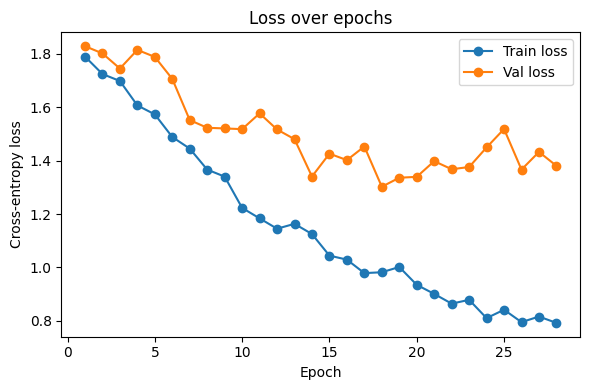

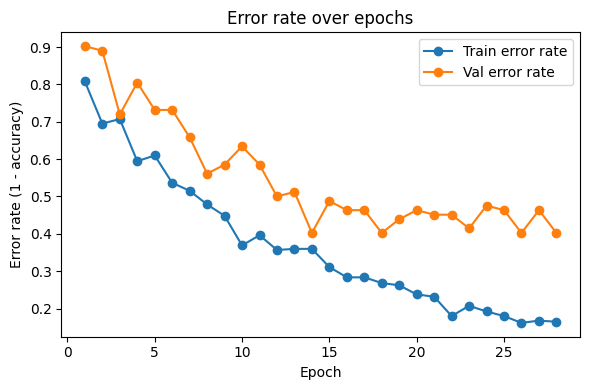

In [15]:
model.eval()
all_labels = []
all_preds = []
all_probs = []  # Store prediction probabilities for ROC/PR curves
all_images = []  # Store images for Grad-CAM visualization

with torch.no_grad():
    for xb, yb in dataloaders["val"]:
        xb = xb.to(device)
        outputs = model(xb)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())
        all_images.extend(xb.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_images = np.array(all_images)

class_names = dataloaders["val"].dataset.classes

macro_precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
macro_recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

print(f"Macro precision: {macro_precision:.4f}")
print(f"Macro recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}\n")

print("Per-class classification report (validation):")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# ---- Loss and error-rate curves ----
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, history["train_loss"], marker="o", label="Train loss")
plt.plot(epochs, history["val_loss"], marker="o", label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("Loss over epochs")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, history["train_err"], marker="o", label="Train error rate")
plt.plot(epochs, history["val_err"], marker="o", label="Val error rate")
plt.xlabel("Epoch")
plt.ylabel("Error rate (1 - accuracy)")
plt.title("Error rate over epochs")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Interactive training history dashboard
history_ui = training_history_dashboard(history)
history_ui


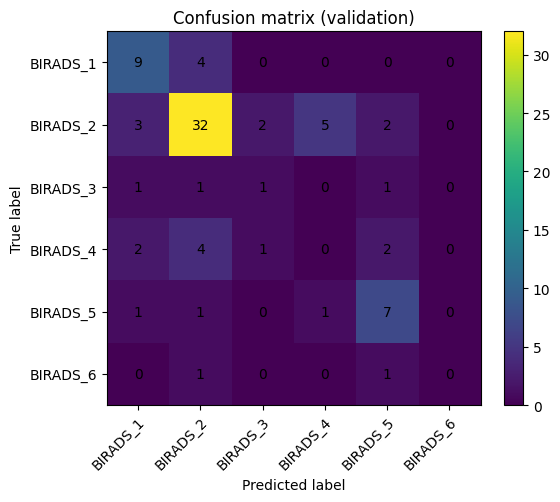

In [17]:
# ---- Confusion matrix ----
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel="True label",
    xlabel="Predicted label",
    title="Confusion matrix (validation)",
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate each cell with the count
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j,
            i,
            int(cm[i, j]),
            ha="center",
            va="center",
        )

plt.tight_layout()
plt.show()

In [18]:
# Interactive confusion matrix dashboard
cm_ui = confusion_matrix_dashboard(all_labels, all_preds, class_names)
cm_ui


## 4. Advanced Evaluation Visualizations

Beyond basic metrics, we examine model performance through:
- **ROC Curves**: Trade-off between sensitivity and specificity per class
- **Precision-Recall Curves**: Especially informative for imbalanced classes
- **Per-Class Metrics**: Side-by-side comparison of F1, precision, and recall
- **Confidence Distribution**: How confident is the model on correct vs incorrect predictions?
- **Grad-CAM**: Visual explanations of what regions drive predictions

In [19]:
from src.utils.model_evaluation import (
    plot_precision_recall_curves,
    plot_class_metrics_bar,
    plot_confidence_distribution,
    get_efficientnet_target_layer,
)
from src.utils.xnat_voila_dashboards import roc_curves_dashboard, gradcam_dashboard

In [20]:
# Interactive ROC Curves - toggle classes on/off with checkboxes
roc_ui = roc_curves_dashboard(all_labels, all_probs, class_names)
roc_ui

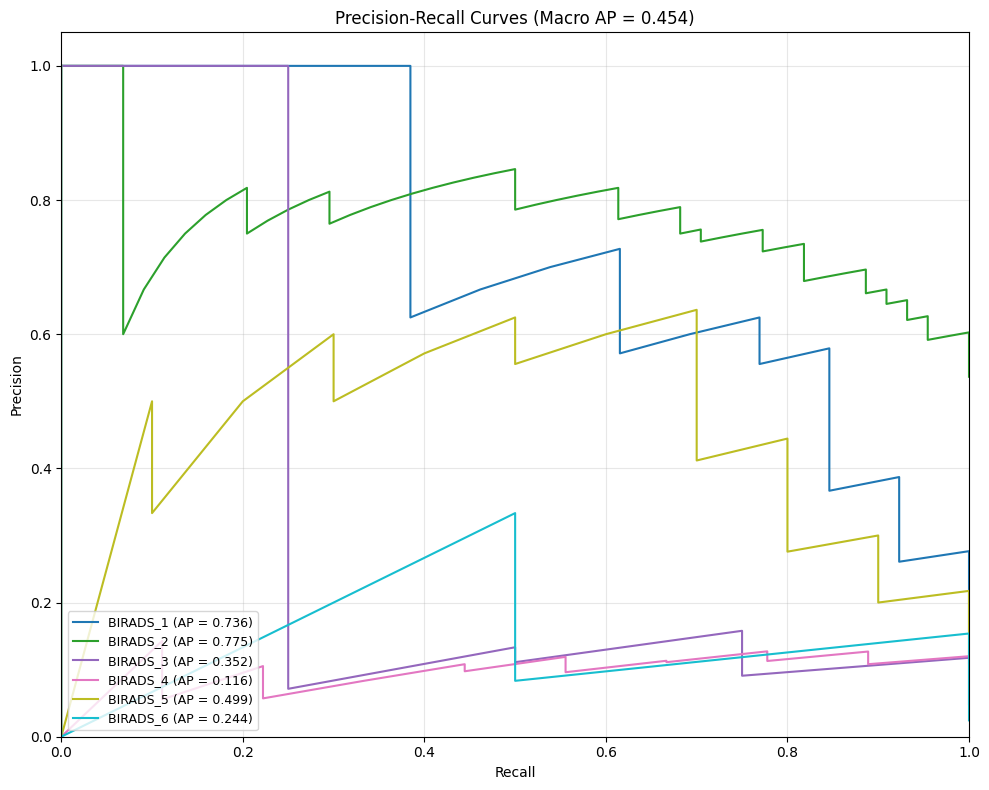

In [21]:
# Precision-Recall Curves - more informative than ROC for imbalanced datasets
fig_pr = plot_precision_recall_curves(all_labels, all_probs, class_names)
plt.show()

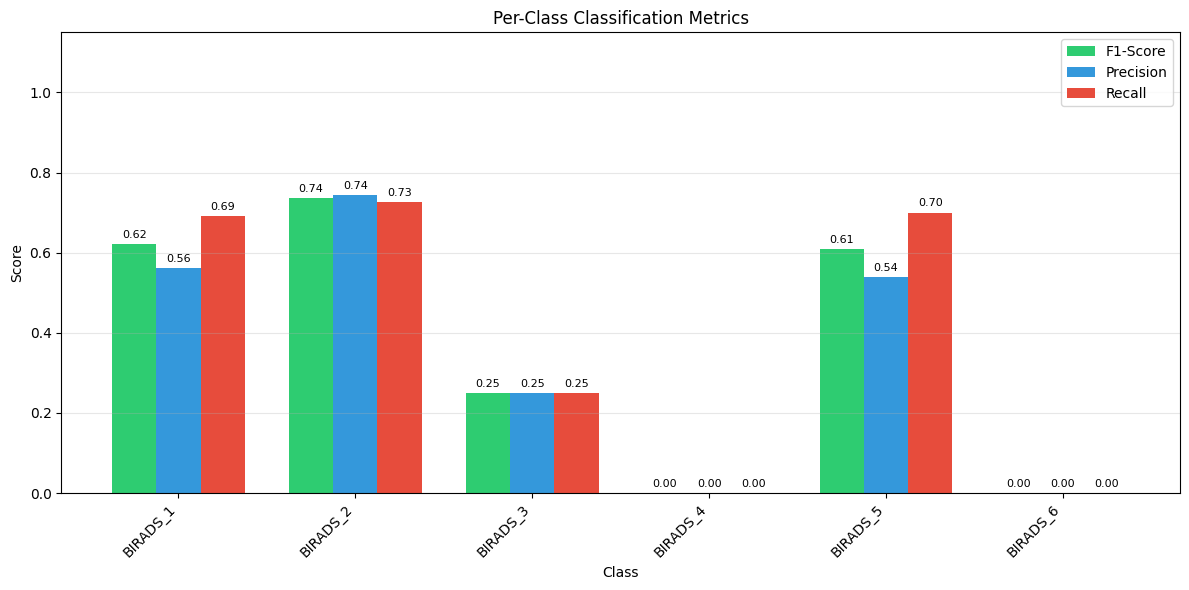

In [22]:
# Per-class metrics comparison - identify which classes the model struggles with
fig_metrics = plot_class_metrics_bar(all_labels, all_preds, class_names)
plt.show()

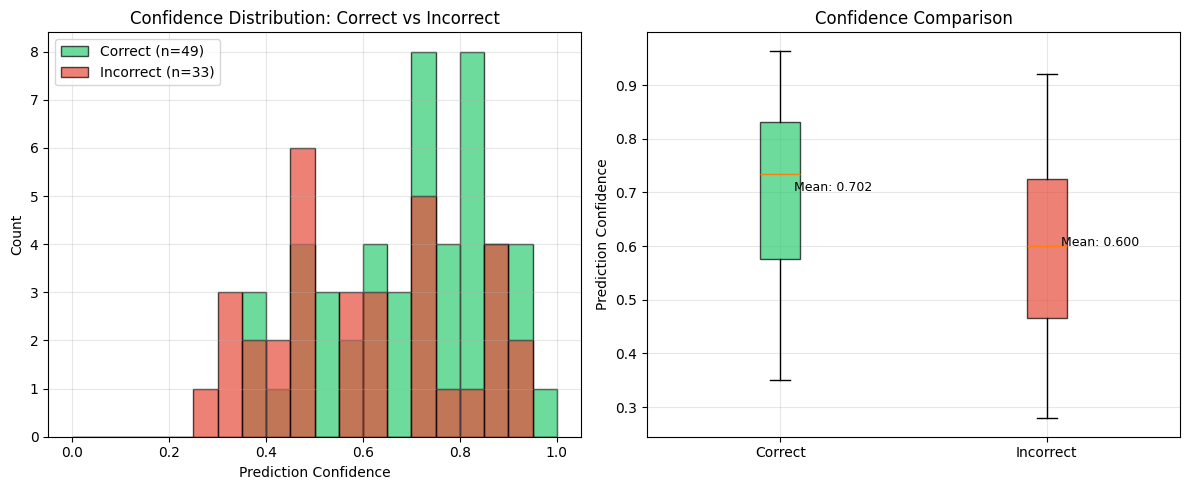

In [23]:
# Confidence distribution - compare model confidence on correct vs incorrect predictions
fig_conf = plot_confidence_distribution(all_labels, all_preds, all_probs)
plt.show()

In [24]:
# Interactive Grad-CAM visualization - navigate through samples with buttons
# Filter by correct/incorrect predictions and see which regions drive the model's decisions
target_layer = get_efficientnet_target_layer(model)
gradcam_ui = gradcam_dashboard(
    model=model,
    images=all_images,
    labels=all_labels,
    preds=all_preds,
    probs=all_probs,
    class_names=class_names,
    target_layer=target_layer,
    device=str(device),
)
gradcam_ui

## 5. Save Training Run

Save all training data for later comparison with other runs. This allows you to:
- Compare different model architectures
- Compare different hyperparameter settings
- Track experiment history over time

In [25]:
from src.utils.training_runs import create_training_run, save_training_run

# Create a training run with all the data needed for dashboards
run = create_training_run(
    run_name=HPARAMS["run_name"],
    model_name=HPARAMS["model_name"],
    history=history,
    labels=all_labels,
    preds=all_preds,
    probs=all_probs,
    class_names=class_names,
    images=all_images,  # Optional: set to None to save disk space
    hyperparameters=HPARAMS,  # Save all hyperparameters
    notes=HPARAMS["notes"],
)

# Save the run to disk
save_training_run(
    run,
    save_dir="training_runs",
    save_images=True,  # Set to False to save disk space (Grad-CAM won't work without images)
    save_model=False,  # Set to True if you want to reload model weights later
)

Saved training run 'EfficientNet-B0 with augmentation_dim448_e30' to training_runs/20251205_160316


PosixPath('training_runs/20251205_160316')

## 6. Compare Training Runs

Use this dashboard to compare saved training runs. You can:
- Select different runs from the dropdown
- View summary metrics, loss curves, ROC curves, and confusion matrices
- Compare all runs side-by-side

In [26]:
from src.utils.xnat_voila_dashboards import run_comparison_dashboard

# Launch the run comparison dashboard
comparison_ui = run_comparison_dashboard(runs_dir="training_runs")
comparison_ui